In [68]:
from torch.utils.data import Dataset, DataLoader
import kagglehub
import torchvision.transforms as T
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

In [33]:
to_tensor = T.ToTensor()

def load_image(path):
    return to_tensor(Image.open(path))


def show_images(imgs):
    # imgs is a tensor of shape: B x C x H x W
    grid = make_grid(imgs, nrow=4, padding=10, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.gcf().set_figwidth(8)
    plt.show()


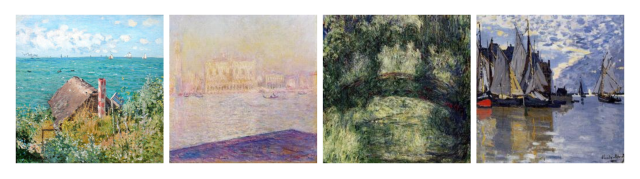

Saving resized images...


100%|██████████| 863/863 [00:00<00:00, 229122.95it/s]


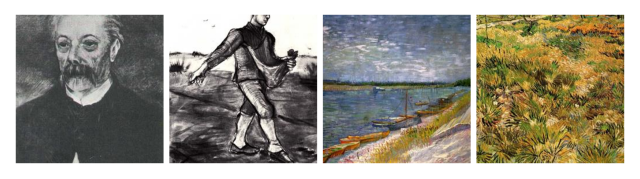

In [110]:
class Monet(Dataset):
    def __init__(self):
        self.data_path = kagglehub.dataset_download(
            "dimitreoliveira/monet-paintings-jpg-berkeley")
        self.img_names = os.listdir(self.data_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.data_path, self.img_names[index]))


class VanGogh(Dataset):
    def __init__(self):
        self.data_path = kagglehub.dataset_download(
            "ipythonx/van-gogh-paintings")
        self.df = pd.read_csv(os.path.join(
            self.data_path, "VanGoghPaintings.csv"))

        # only use folders containing painting images
        exclude = ["Drawings", "Sketches in letters",
                   "Works of the young van Gogh"]
        mask = ~self.df["class_name"].isin(exclude)
        self.img_names = self.df[mask]["image_path"].reset_index(drop=True)

        # remove unused path prefix, replace with correct prefix
        self.img_names = self.img_names.apply(
            lambda x: x.replace("/kaggle/input/van-gogh-paintings/", "VincentVanGogh/"))

        # resize images to lower resolution and square, to match monet data
        print("Saving resized images...")
        for img_name in tqdm(self.img_names):
            resized_path = os.path.join(self.data_path, "resized", img_name)
            if os.path.exists(resized_path):
                continue

            # crop to a square and resize to small resolution
            img_path = os.path.join(self.data_path, img_name)
            with Image.open(img_path) as img:
                # get the shorter side of the image and calculate cropping offsets
                short_side = min(img.width, img.height)
                left = (img.width - short_side) // 2
                top = (img.height - short_side) // 2
                right = left + short_side
                bottom = top + short_side

                # crop the image to a square, and resize
                cropped_img = img.crop((left, top, right, bottom))
                resized_img = cropped_img.resize((256, 256))

                # save
                os.makedirs(os.path.dirname(resized_path), exist_ok=True)
                resized_img.save(resized_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.data_path, "resized", self.img_names[index]))


monet_loader = DataLoader(Monet(), batch_size=4, shuffle=True)
show_images(next(iter(monet_loader)))

van_gogh_loader = DataLoader(VanGogh(), batch_size=4, shuffle=True)
show_images(next(iter(van_gogh_loader)))